Garrepalli Vaishnavi

https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
import missingno as msno
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DatasetBaseFolder = '/content/gdrive/MyDrive/Colab Notebooks/Classification/Dataset/'

In [5]:
df = pd.read_csv(DatasetBaseFolder+'bank-additional-full.csv', sep=';')

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


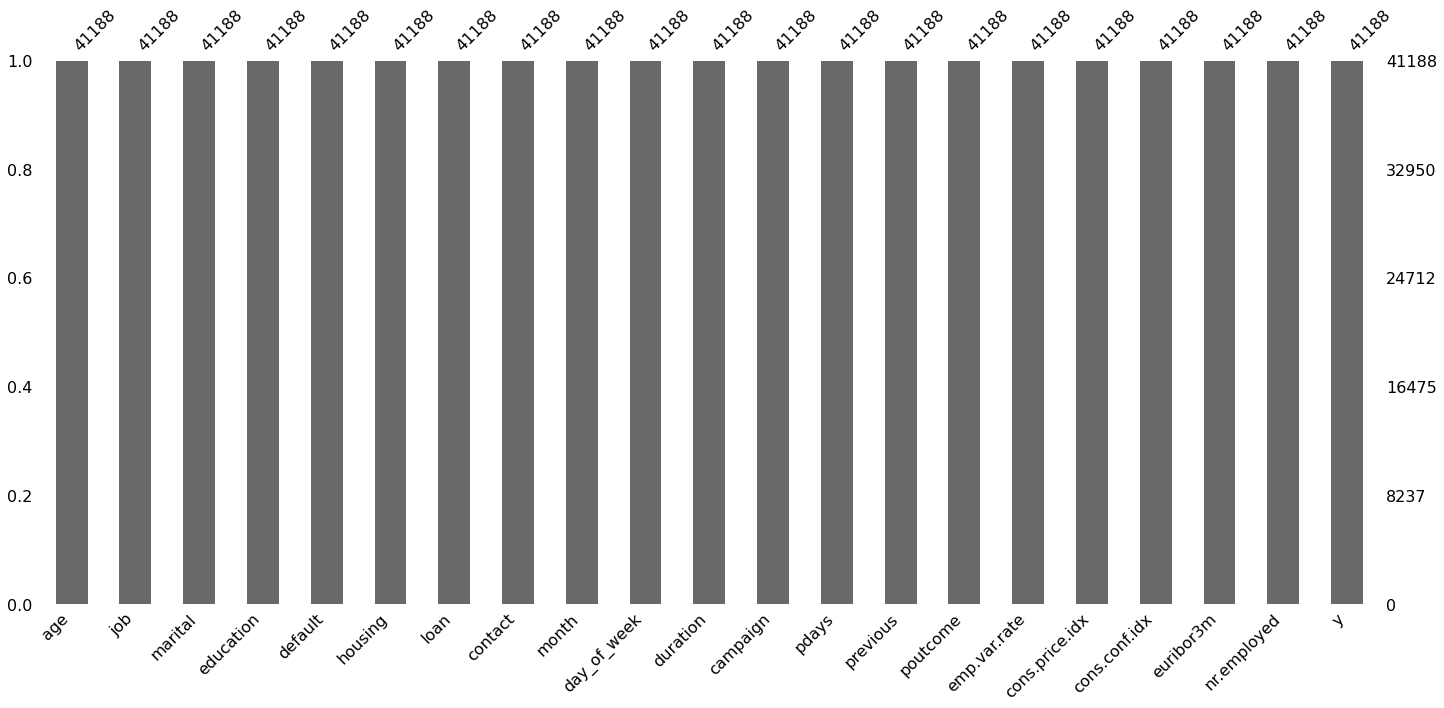

In [7]:
msno.bar(df)

In [8]:
# Split into predictor and response dataframes.
X_df = df.drop('y', axis=1)
y = df['y']

X_df.shape,y.shape

((41188, 20), (41188,))

In [9]:
# Map response variable to integers 0,1.
y = pd.Series(np.where(y.values == 'yes',1,0), y.index)
y.value_counts()

0    36548
1     4640
dtype: int64

In [10]:
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [11]:
# Label encode categorical variables.
label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([X_df, pd.get_dummies(X_df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(X_df, 'education', educ_order)
ordered_labels(X_df, 'month', month_order)
ordered_labels(X_df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(X_df):
    if X_df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(X_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
0,56,1,2,0,0,0,1,2,0,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0
1,57,1,5,1,0,0,1,2,0,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
2,37,1,5,0,2,0,1,2,0,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0
3,40,1,3,0,0,0,1,2,0,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0
4,56,1,5,0,0,2,1,2,0,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0


In [12]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [13]:
# Split feature and label sets to train and data sets.
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32950, 31), (8238, 31), (32950,), (8238,))

In [14]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   14.4s finished


In [16]:
best_clf.best_estimator_.get_params()['classifier']

LogisticRegression(C=0.615848211066026, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9061665452779801


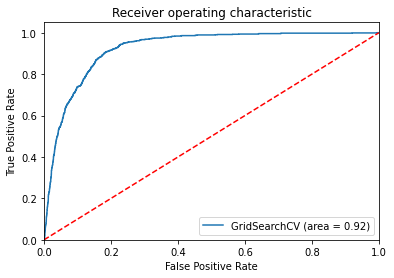

In [18]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

If false negatives are worse than false positives, then choose a cutoff with high sensitivity (a value higher on the Y axis ofthe ROC graph). Alternatively, if false positives are worse, then pick a cutoff with high specificity (values to the left in the ROC graph).

In [19]:
roc_auc

0.9229761722251051

In [20]:
probs

array([[0.93557021, 0.06442979],
       [0.88887051, 0.11112949],
       [0.5584526 , 0.4415474 ],
       ...,
       [0.98173039, 0.01826961],
       [0.98852865, 0.01147135],
       [0.98682219, 0.01317781]])

In [21]:
classes = best_clf.predict(X_test)  

In [22]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7689
           1       0.38      0.64      0.48       549

    accuracy                           0.91      8238
   macro avg       0.68      0.78      0.71      8238
weighted avg       0.93      0.91      0.92      8238

